In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# interest rate for Net Present Value calculations
rate = 4/100; # 4.0#
# data for generator dispatch problem
D = 365; # days in a year
Y = 20; # years simulated
T = 24; # hours simulated in each day
t= np.arange(T); # vector of time
d = 40 * np.array([
    0.4, 0.4, 0.4, 0.65,
    0.65, 0.6, 0.6, 0.65,
    0.8, 0.85, 0.8, 0.8,
    0.75, 0.6, 0.5, 0.3, 
    0.3, 0.4, 0.54, 0.6, 
    0.75, 0.7, 0.6, 0.5
]) # daily demand in MWh
n = 4; # number of dispatchable generators (2 hard coal and 2 OCGT plants) to choose from,
# in addition to a solar plant
solar_cap_fact = np.concatenate((
    np.zeros(6),
    np.sin(np.pi*np.arange(0, 13)/12),
    np.zeros(24-6-(np.arange(0,13).size))
))
# capacity factor of the potential solar plant = power_available/installed_capacity
# (To be used in Part II only: capacity factor of the potential wind plant = power_available/installed_capacity)
wind_cap_fact = np.array([
    0.3277, 0.2865, 0.3303, 0.3073, 0.2994, 0.3071,
    0.2980, 0.2988, 0.3149, 0.3141, 0.3142, 0.5*0.3067, 
    0.5*0.2879, 0.5*0.3072, 0.5*0.3163, 0.5*0.3049, 0.5*0.3103, 
    0.3914, 0.4008 , 0.3879, 0.3889, 0.3999, 0.4153, 0.3923
])
Pmax = np.array([10, 5, 10, 15]) 
# Maximum generator capacities in MW [hard coal, hard coal, OCGT, OCGT] due to land constraints
Pmax_solar = 40; # Maximum capacity in MW for solar plant due to land constraints
Pmin = np.zeros(4) # generator minimum capacities in MW
Pmin_solar = 0;
ramp_hard_coal = 0.015 # 1.5# [# Pnom/minute]
hourly_ramp_hard_coal = ramp_hard_coal*60; # [# Pnom/h]
ramp_ocgt = 0.08 # 1.5# [# Pnom/min]
hourly_ramp_ocgt = ramp_ocgt*60; # [# Pnom/h]
R = np.array([hourly_ramp_hard_coal, hourly_ramp_hard_coal, hourly_ramp_ocgt, hourly_ramp_ocgt]) * Pmax 
# [hourly_ramp_hard_coal*Pmax[0], hourly_ramp_hard_coal*Pmax[1], hourly_ramp_ocgt*Pmax[2], hourly_ramp_ocgt*Pmax[3]]; # ramp-rate limits [MWh]
# source:
# https://www.eia.gov/electricity/annual/html/epa_08_04.html
#
fuel_cost_per_MWh_2018 = np.array([25.4, 25.4, 27.35, 27.35]); # $/MWh, 2018
#
#fuel_cost_per_MWh_2019 = [24.28 24.28 23.11 23.11]; # $/MWh, 2019 This
#cost won't be used
# Investment costs (or capital costs per MW of built capacity). From https://atb.nrel.gov/
capital_cost_solar_plant_per_MW = 1200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_wind_plant_per_MW = 1300000; # dollars/MW, denoted as M_i in the pdf
capital_cost_coal_plant = 4200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_gas_plant = 2600000; # dollars/MW, denoted as M_i in the pdf
# Emission rates of pounds of CO_2 per kWh for each tech (https://www.eia.gov/tools/faqs/faq.php?id=74&t=11)
co2_coal = 2.30; # pounds per kWh
co2_gas = 0.97; # pounds per kWh
co2_solar = 0;
# Remember to convert these to pounds/MWh for consistency in your units

#####
# part I
#####

print('***\nPart I\n***')
# define variables
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable();

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_thermal_capacity <= Pmax,
    installed_solar_capacity <= Pmax_solar,
    cp.sum(p, axis=0) + p_solar >= d,
    p >= 0,
    p_solar >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity

daily_fuel_costs = cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis])
yearly_fuel_costs = 365 * cp.sum(daily_fuel_costs, axis=1)
NPV_multipliers = np.power((1 + rate), -1 * (np.arange(20)+1))
NPV_fuel_costs = cp.multiply(yearly_fuel_costs[:, np.newaxis], NPV_multipliers)

# solve
problem = cp.Problem(cp.Minimize(
    cp.sum(NPV_fuel_costs) + cp.sum(thermal_investment_costs) + solar_investment_cost
), constraints)

# Use CVXOPT if installed, otherwise use default solver.
try:
    problem.solve(solver='CVXOPT', kktsolver='robust', feastol=1e-9)
except Exception as e:
    print(e)
    problem.solve()

total_NPV_cost = problem.value
installed_capacity = np.concatenate((installed_thermal_capacity.value, [installed_solar_capacity.value]))
power_generation = np.concatenate((p.value, p_solar.value[np.newaxis, :]))
investment_costs = np.concatenate((thermal_investment_costs.value, [solar_investment_cost.value]))
thermal_plant_NPV_fuel_costs = NPV_fuel_costs.value

print(f'Total NP:\t${problem.value:_.2f}')
print(f'Thermal capacity:\t{installed_thermal_capacity.value} MWh')
print(f'Solar capacity:\t{installed_solar_capacity.value} MWh')

#####
# part II
#####

print('***\nPart II\n***')
# define variables
Pmin_wind = 0
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
p_wind = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable()
installed_wind_capacity = cp.Variable()

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_wind_capacity >= Pmin_wind,
    installed_thermal_capacity <= Pmax,
    cp.sum(p, axis=0) + p_solar + p_wind >= d,
    p >= 0,
    p_solar >= 0,
    p_wind >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    p_wind <= wind_cap_fact * installed_wind_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

RPS = (cp.sum(p_solar)+cp.sum(p_wind)) / cp.sum(d)
RPS_constraints = np.concatenate(([0], np.arange(0.94, 1, 0.01)))

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity
wind_investment_cost = capital_cost_wind_plant_per_MW * installed_wind_capacity

daily_fuel_costs = cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis])
yearly_fuel_costs = 365 * cp.sum(daily_fuel_costs, axis=1)
NPV_fuel_costs = cp.multiply(yearly_fuel_costs[:, np.newaxis], NPV_multipliers)

# solve
total_NPV_costs = np.zeros(8)
installed_capacities_2 = np.zeros((8, 6))
curtailments = np.zeros(8)
RPS_values = np.zeros(8)
power_generation_2 = np.zeros((8, 6, 24))

for i in range(8):
    problem = cp.Problem(cp.Minimize(
            cp.sum(NPV_fuel_costs) 
            + cp.sum(thermal_investment_costs) 
            + solar_investment_cost 
            + wind_investment_cost
        ), constraints + [RPS >= RPS_constraints[i]]
    )

    try:
        problem.solve(solver='CVXOPT', kktsolver='robust', feastol=1e-9)
    except Exception as e:
        print(e)
        problem.solve()

    total_NPV_costs[i] = problem.value
    installed_capacities_2[i, :] = np.concatenate((
        installed_thermal_capacity.value,
        [installed_solar_capacity.value],
        [installed_wind_capacity.value]
    ))
    curtailments[i] = np.sum(p.value) + np.sum(p_solar.value) + np.sum(p_wind.value) - np.sum(d)
    RPS_values[i] = RPS.value
    power_generation_2[i, :, :] = np.concatenate((
        p.value,
        p_solar.value[np.newaxis, :],
        p_wind.value[np.newaxis, :]
    ))

    print(f'RPS\t{RPS.value:.2%}')
    print(f'Total NP:\t${problem.value:_.2f}')
    print(f'Thermal capacity:\t{installed_thermal_capacity.value} MWh')
    print(f'Solar capacity:\t{installed_solar_capacity.value} MWh')
    print(f'Wind capacity:\t{installed_wind_capacity.value} MWh\n')


***
Part I
***


C:\Users\LW\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Total NP:	$162_532_337.42
Thermal capacity:	[ 2.51402181  2.48597819 10.         15.        ] MWh
Solar capacity:	5.656854249916123 MWh
***
Part II
***
RPS	88.64%
Total NP:	$126_187_223.04
Thermal capacity:	[5.79281754e-09 5.73681302e-09 4.29697188e+00 4.40083691e+00] MWh
Solar capacity:	14.949557561184303 MWh
Wind capacity:	57.78954972443412 MWh

RPS	94.00%
Total NP:	$126_228_824.93
Thermal capacity:	[1.72999514e-09 1.72528345e-09 4.16105374e+00 4.23520437e+00] MWh
Solar capacity:	15.101845784690047 MWh
Wind capacity:	58.7967330859807 MWh

RPS	95.00%
Total NP:	$126_257_177.32
Thermal capacity:	[3.60753499e-10 3.59652225e-10 4.06015469e+00 4.13059154e+00] MWh
Solar capacity:	15.20563277637585 MWh
Wind capacity:	59.48314552272854 MWh

RPS	96.00%
Total NP:	$126_311_772.12
Thermal capacity:	[1.23525653e-08 1.23526152e-08 3.96071356e+00 4.02452076e+00] MWh
Solar capacity:	15.309419767677065 MWh
Wind capacity:	60.16955792435833 MWh

RPS	97.00%
Total NP:	$126_409_483.34
Thermal capacity:	[1.

# Part I

## Part I report

In [9]:
# report
power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar']

print(f'2. The NPV of of the cost is ${total_NPV_cost:_.2f}')
print(f'3. The optimal installed capacities are: ')

for i in range(5):
    print(f'\t {power_plants[i]}: {installed_capacity[i]:.3f} MW')

2. The NPV of of the cost is $162_532_337.42
3. The optimal installed capacities are: 
	 Coal 1: 2.514 MW
	 Coal 2: 2.486 MW
	 Gas 1: 10.000 MW
	 Gas 2: 15.000 MW
	 Solar: 5.657 MW


Text(0.5, 0.98, '4. Part I plots')

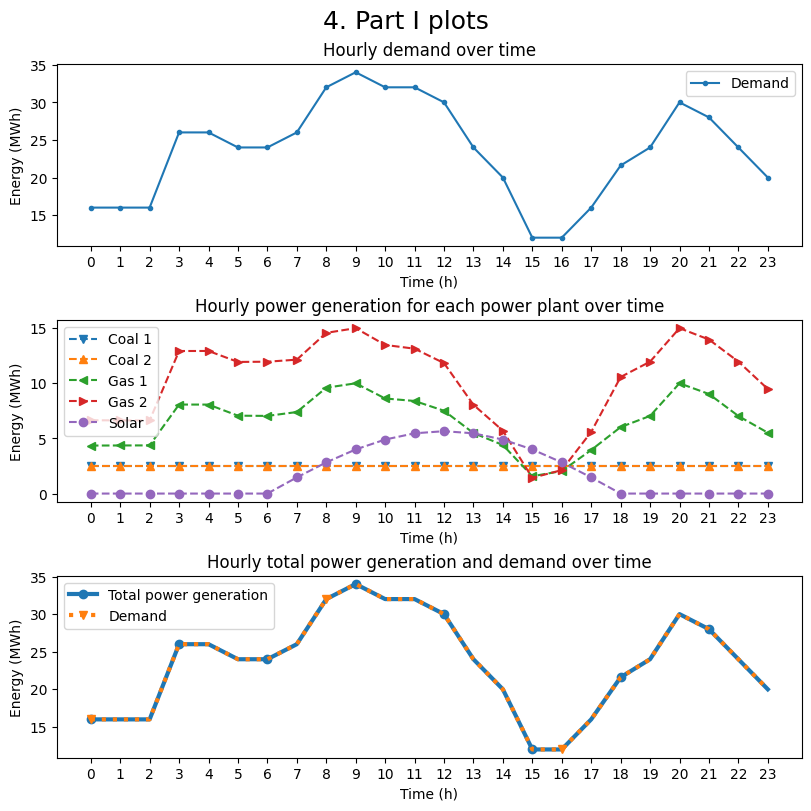

In [10]:
# figures
fig, ax = plt.subplots(3, layout='constrained', figsize=(8, 8))

markers = ['v', '^', '<', '>', 'o']

ax[0].plot(t, d, marker='.', label='Demand')
ax[0].set_title('Hourly demand over time')

for i in range(5):
    ax[1].plot(t, power_generation[i, :], ls='--', marker=markers[i], label=power_plants[i])

ax[1].set_title('Hourly power generation for each power plant over time')

ax[2].plot(t,  np.sum(power_generation, axis=0), ls='-', lw=3, marker='o', markevery=3, label='Total power generation')
ax[2].plot(t,  d, ls=':', lw=3, marker='v', markevery=8, label='Demand')
ax[2].set_title('Hourly total power generation and demand over time')

for i in range(3):
    ax[i].set_xlabel('Time (h)')
    ax[i].set_xticks(t)
    ax[i].set_ylabel('Energy (MWh)')
    ax[i].legend()

fig.suptitle('4. Part I plots', fontsize=18)

In [5]:
# LCOE
yearly_dispatched_electricity = 365 * np.sum(power_generation, axis=1)
NPV_optimal_dispatched_electricity = np.sum(yearly_dispatched_electricity[:, np.newaxis]*NPV_multipliers, axis=1)
total_fuel_costs = np.concat((thermal_plant_NPV_fuel_costs, np.zeros((1, 20))))
NPV_costs = investment_costs + np.sum(total_fuel_costs, axis=1)
LCOE = NPV_costs / NPV_optimal_dispatched_electricity

print('5.')
for i in range(5):
    print(f'\tLCOE of {power_plants[i]}: ${LCOE[i]:.2f}/MWh')

5.
	LCOE of Coal 1: $60.68/MWh
	LCOE of Coal 2: $60.68/MWh
	LCOE of Gas 1: $60.75/MWh
	LCOE of Gas 2: $59.35/MWh
	LCOE of Solar: $31.85/MWh


# Part II report

Text(0.5, 0.98, 'Part II summary plots')

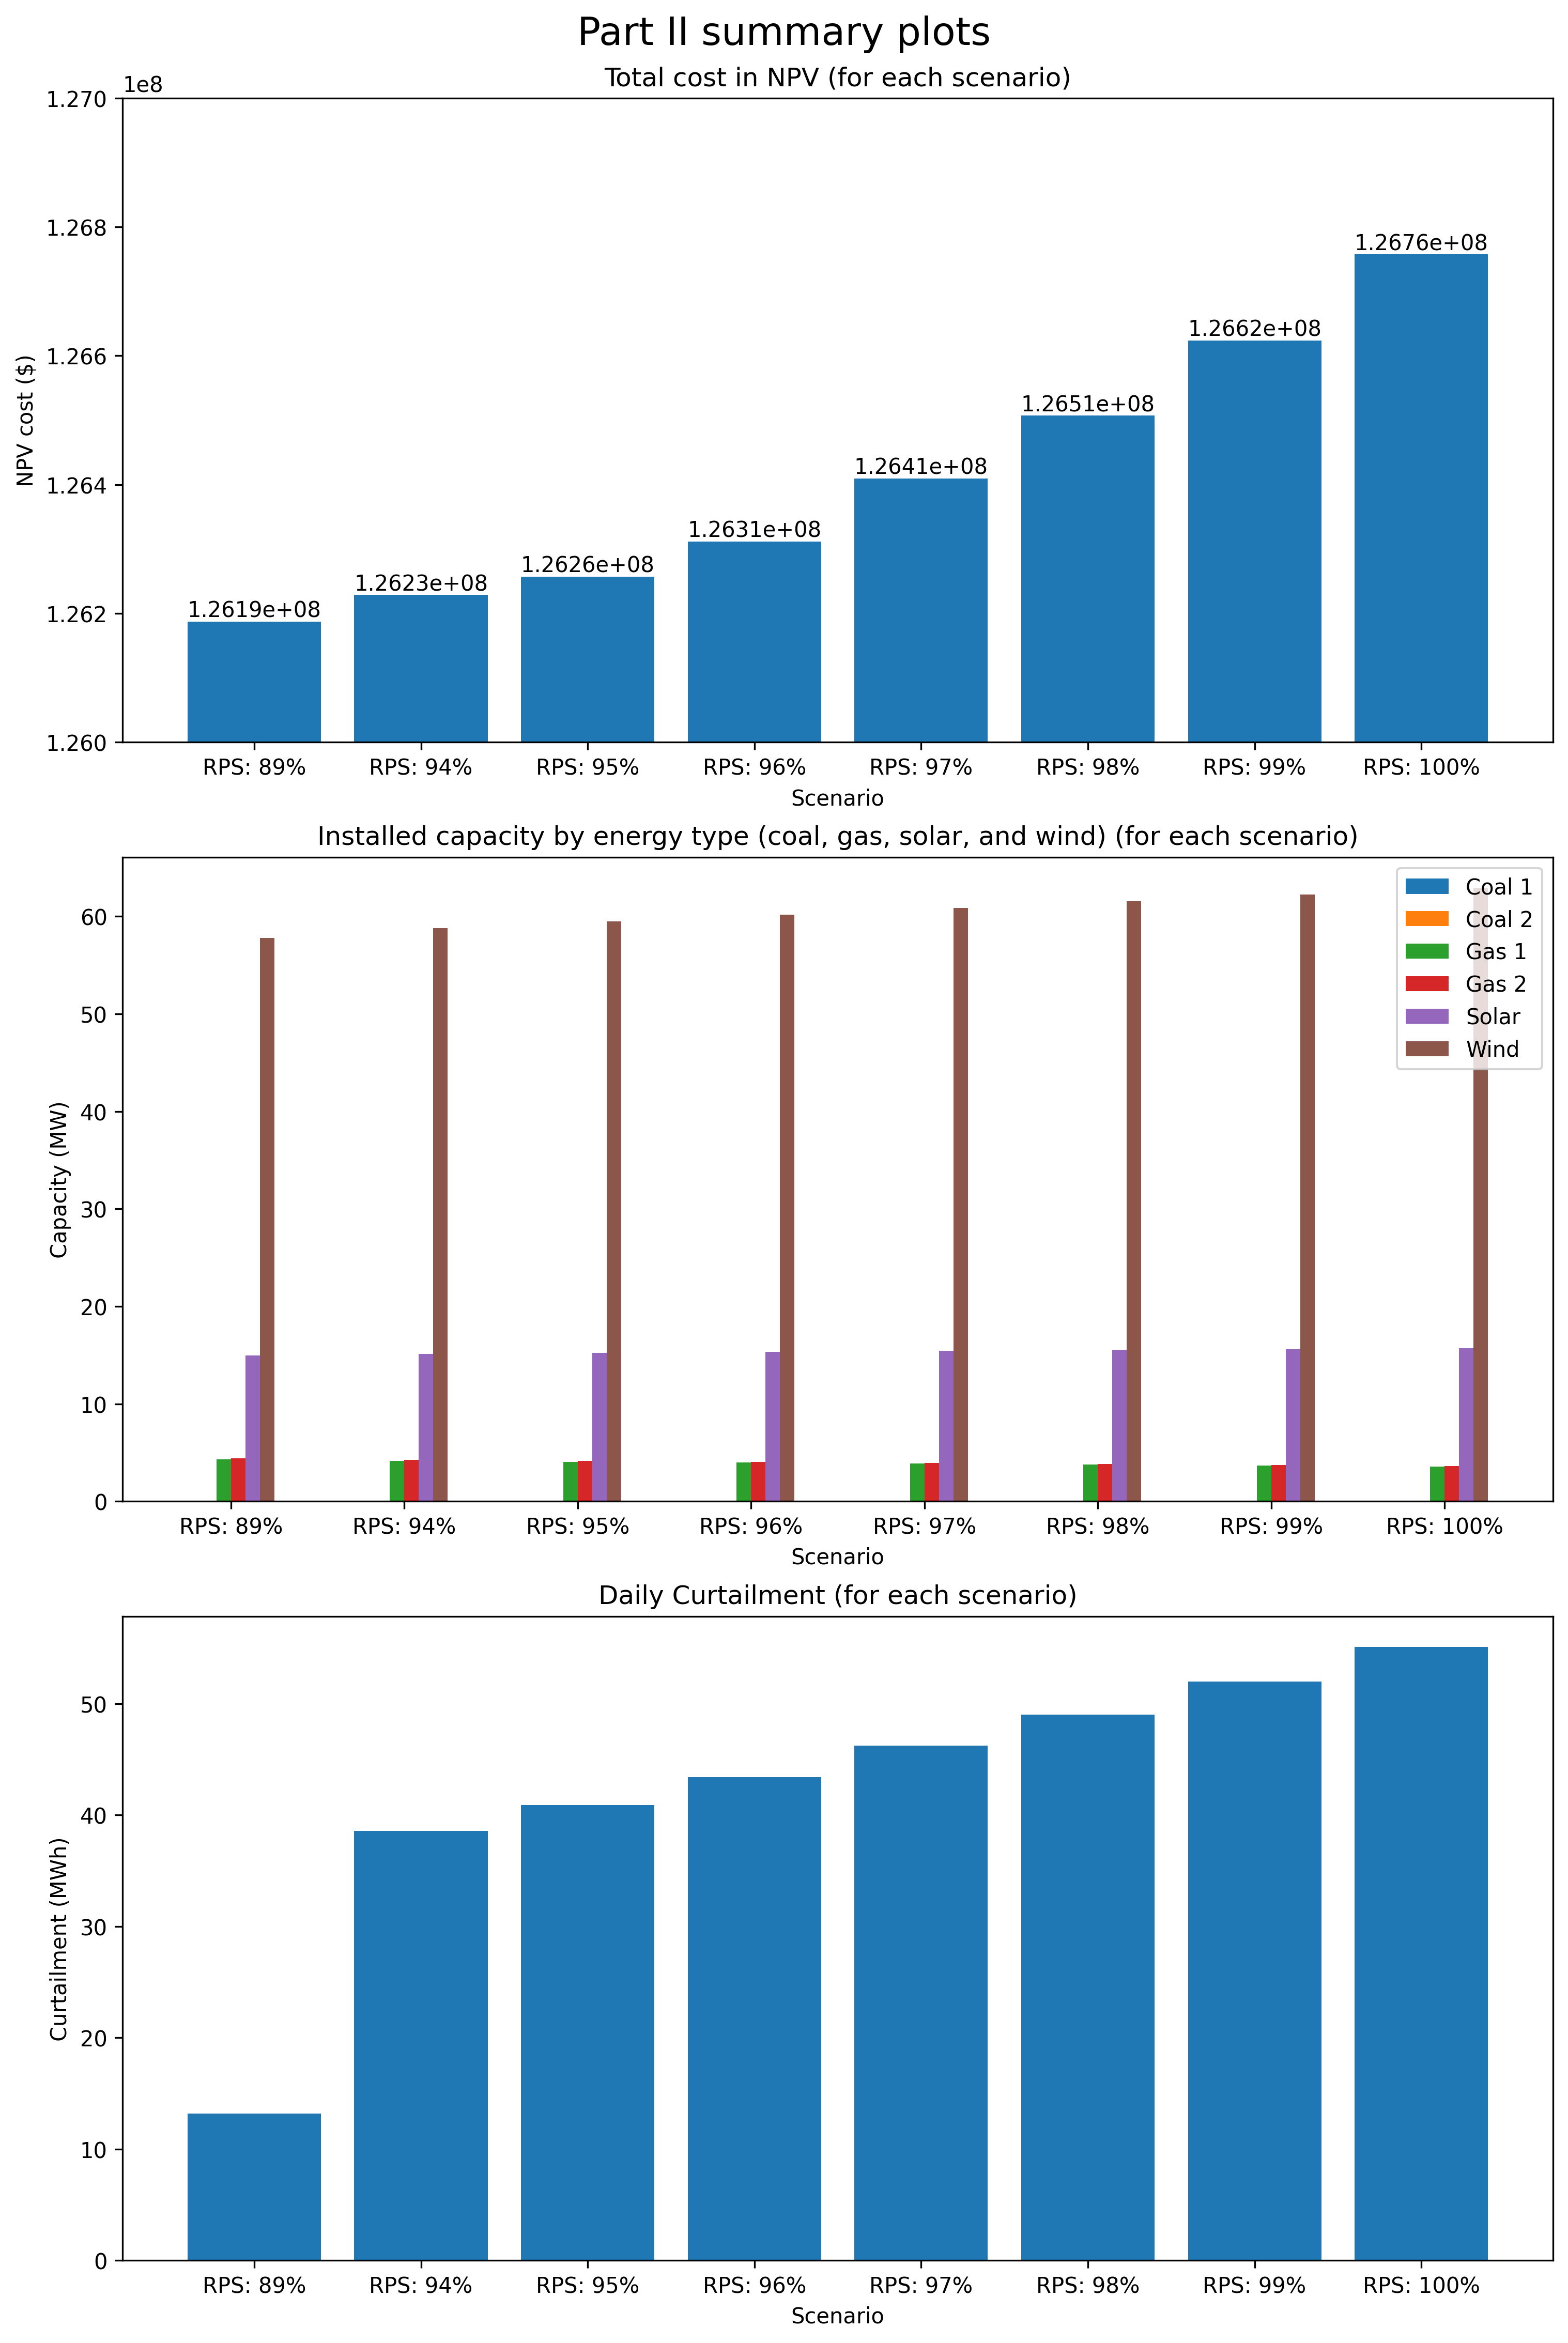

In [23]:
fig, ax = plt.subplots(3, figsize=(10, 15), layout='constrained', dpi=300)

rects = ax[0].bar(range(8), total_NPV_costs)
ax[0].bar_label(rects, fmt='{:_.4e}')
ax[0].set_ylim((1.26e8, 1.27e8))
ax[0].set_ylabel('NPV cost ($)')
ax[0].set_title('Total cost in NPV (for each scenario)')

power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar', 'Wind']
offsets = (np.arange(-3, 3)+0.5) / 12
for i in range(6):
    ax[1].bar(np.arange(8)+offsets[i], installed_capacities_2[:, i], width=1/12, label=power_plants[i])
    
ax[1].set_ylabel('Capacity (MW)')
ax[1].set_title('Installed capacity by energy type (coal, gas, solar, and wind) (for each scenario)')
ax[1].legend()

ax[2].bar(range(8), curtailments)
ax[2].set_ylabel('Curtailment (MWh)')
ax[2].set_title('Daily Curtailment (for each scenario)')

scenarios = [f'RPS: {rps:.0%}' for rps in RPS_values]
for a in ax:
    a.set_xlabel('Scenario')
    a.set_xticks(np.arange(8), scenarios)

fig.suptitle('Part II summary plots', fontsize=18)

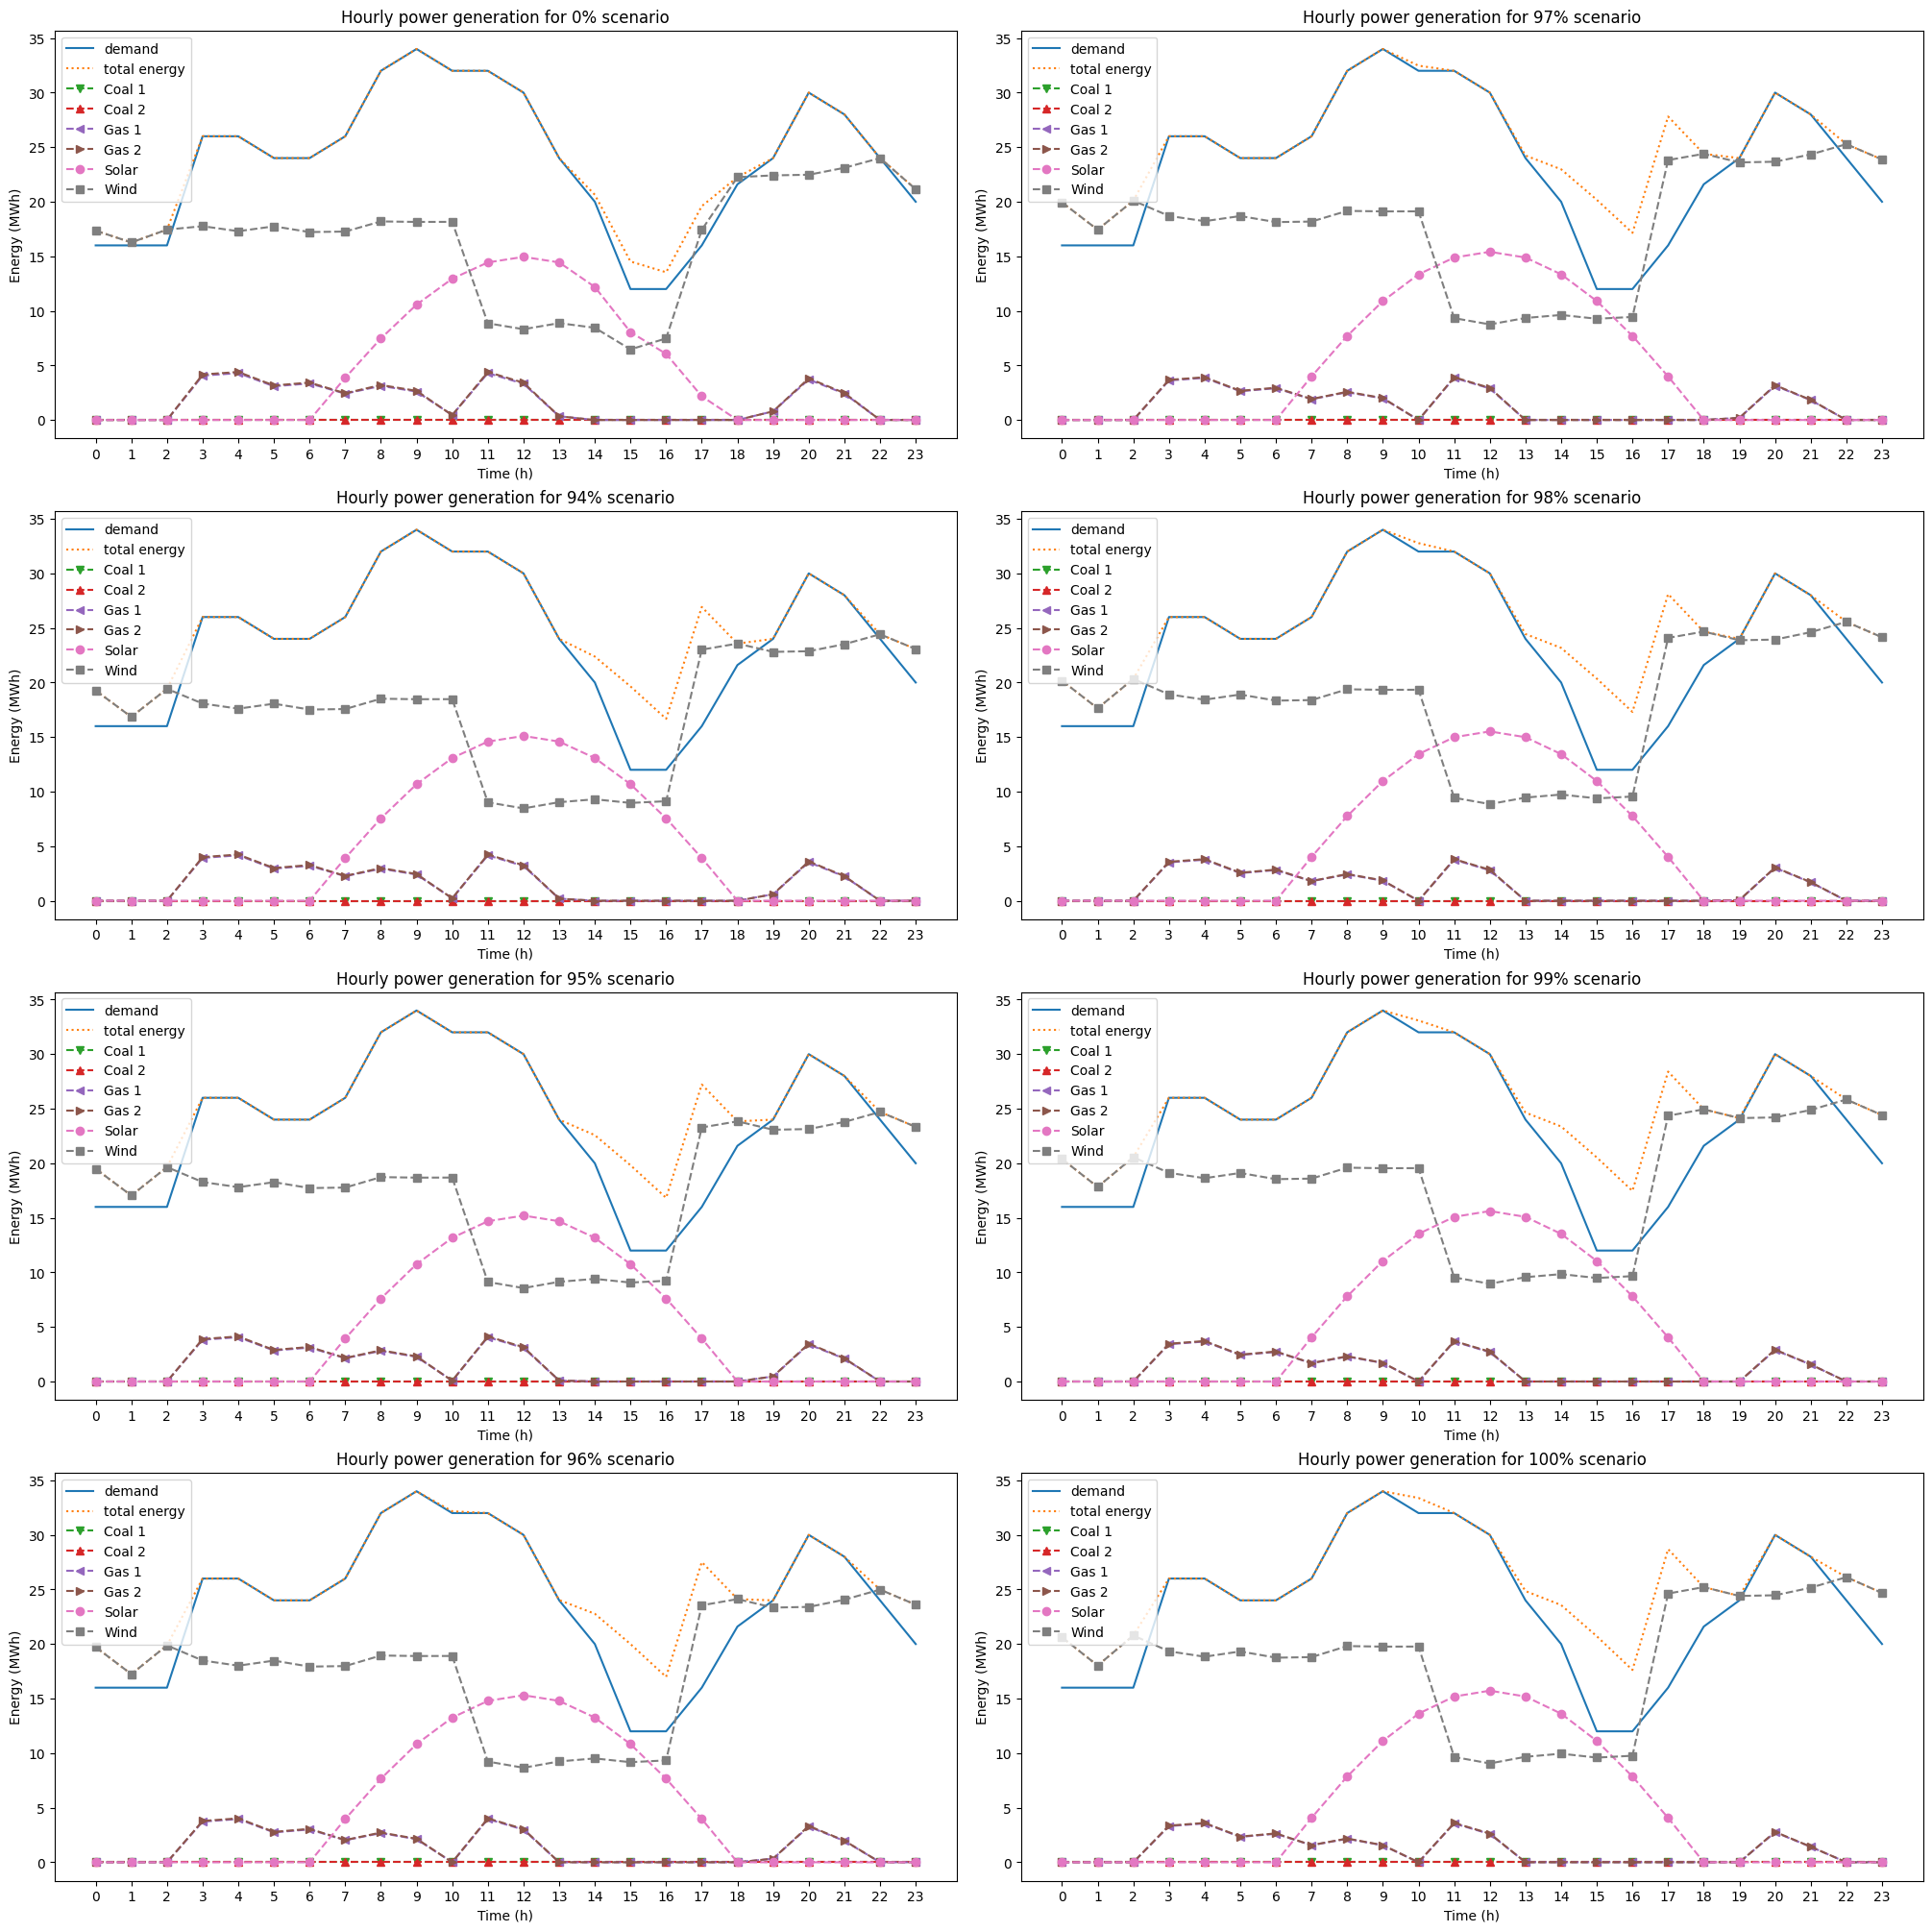

In [15]:
# baseline analysis
fig, ax = plt.subplots(4, 2, layout='constrained', figsize=(20, 20))

markers = ['v', '^', '<', '>', 'o', 's']
for i in range(8):
    n = i%4
    m = i//4
    ax[n, m].plot(t, d, label='demand')
    ax[n, m].plot(t, np.sum(power_generation_2[i, :, :], axis=0), ls=':', label='total energy')
    for j in range(6):
        ax[n, m].plot(t, power_generation_2[i, j, :], ls='--', marker=markers[j], label=power_plants[j])
        
    ax[n, m].set_title(f'Hourly power generation for {RPS_constraints[i]:.0%} scenario')
    ax[n, m].set_xlabel('Time (h)')
    ax[n, m].set_xticks(t)
    ax[n, m].set_ylabel('Energy (MWh)')
    ax[n, m].legend(loc='upper left')